# Model Training for Bathymetry Estimation

This notebook trains multiple machine learning models for bathymetry estimation from satellite data.

Steps:
1. Load training data from feature generation
2. Train multiple ML models (Linear Regression, Random Forest, XGBoost, Decision Tree)
3. Evaluate model performance
4. Save trained models and metrics

In [1]:
# Parameters
region_name = "kachchh"
training_data_dir = None
output_dir = None

## Setup and Configuration

In [2]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Add project root to path
project_dir = Path().absolute().parent
if project_dir.name != 'sdb_project':
    project_dir = project_dir / 'sdb_project'
sys.path.append(str(project_dir))

# Load configuration
config_path = project_dir / 'config' / 'location_config.json'
with open(config_path) as f:
    config = json.load(f)

# Use parameters if provided
if region_name is None:
    region_name = config['region_name']

# Set up paths
region_slug = region_name.lower().replace(' ', '_')
if training_data_dir is None:
    training_data_dir = project_dir / 'data' / 'sentinel' / region_slug / 'processed' / 'training_data'
if output_dir is None:
    output_dir = project_dir / 'outputs' / region_slug

Path(output_dir).mkdir(parents=True, exist_ok=True)
models_dir = project_dir / 'models'
models_dir.mkdir(exist_ok=True)

print(f"✅ Model training for: {region_name}")
print(f"📁 Training data directory: {training_data_dir}")
print(f"📁 Output directory: {output_dir}")
print(f"📁 Models directory: {models_dir}")

✅ Model training for: kachchh
📁 Training data directory: d:\Project\sdb_project\data\sentinel\kachchh\processed\training_data
📁 Output directory: d:\Project\sdb_project\outputs\kachchh
📁 Models directory: d:\Project\sdb_project\models


## Load Training Data

Load the preprocessed features and synthetic depth data.

In [6]:
# Load training data
# Use the realistic bathymetry data we just generated
processed_data_dir = project_dir / 'data' / 'processed' / region_slug / 'training_data'

features_path = processed_data_dir / 'features.npy'
depths_path = processed_data_dir / 'depths.npy'
metadata_path = processed_data_dir / 'metadata.json'

print(f"📁 Looking for data in: {processed_data_dir}")

# Check if files exist
required_files = [features_path, depths_path, metadata_path]
for file_path in required_files:
    if not file_path.exists():
        raise FileNotFoundError(f"Required training data file not found: {file_path}")

# Load data
features = np.load(features_path)
depths = np.load(depths_path)

# Load metadata
with open(metadata_path) as f:
    metadata = json.load(f)

print(f"✅ Loaded realistic bathymetry training data:")
print(f"📊 Features shape: {features.shape}")
print(f"📊 Depths shape: {depths.shape}")
print(f"📊 Data type: {metadata.get('data_type', 'unknown')}")
print(f"📊 Depth range: {metadata['depth_range'][0]:.1f} - {metadata['depth_range'][1]:.1f} meters")
print(f"📊 Mean depth: {metadata['depth_mean']:.1f} ± {metadata['depth_std']:.1f} meters")

# Remove any remaining invalid samples
valid_mask = ~np.isnan(features).any(axis=1) & ~np.isnan(depths)
features = features[valid_mask]
depths = depths[valid_mask]

print(f"📊 Valid samples after cleaning: {len(features)}")

if len(features) == 0:
    raise ValueError("No valid training samples found!")

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    features, depths, test_size=0.2, random_state=42, stratify=None
)

print(f"📊 Training set: {X_train.shape[0]} samples")
print(f"📊 Test set: {X_test.shape[0]} samples")

📁 Looking for data in: d:\Project\sdb_project\data\processed\kachchh\training_data
✅ Loaded realistic bathymetry training data:
📊 Features shape: (9754, 13)
📊 Depths shape: (9754,)
📊 Data type: realistic_synthetic_bathymetry
📊 Depth range: 0.0 - 107.8 meters
📊 Mean depth: 27.0 ± 14.9 meters
📊 Valid samples after cleaning: 9754
📊 Training set: 7803 samples
📊 Test set: 1951 samples


## Model Training Functions

Define helper functions for training and evaluation.

In [4]:
def evaluate_model(y_true, y_pred, model_name):
    """Calculate evaluation metrics for a model"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2_score': float(r2)
    }
    
    print(f"\n📊 {model_name} Performance:")
    print(f"   MSE:  {mse:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   R²:   {r2:.4f}")
    
    return metrics

def save_model(model, name, metrics, feature_names):
    """Save model and its metadata"""
    model_path = models_dir / f"{name}.joblib"
    joblib.dump(model, model_path)
    
    # Save model metadata
    model_info = {
        'model_name': name,
        'model_path': str(model_path),
        'feature_names': feature_names,
        'n_features': len(feature_names),
        'metrics': metrics,
        'training_samples': len(X_train)
    }
    
    info_path = models_dir / f"{name}_info.json"
    with open(info_path, 'w') as f:
        json.dump(model_info, f, indent=2)
    
    print(f"✅ Saved {name} model to {model_path}")
    return model_path

# Initialize results storage
model_results = {}
trained_models = {}

## Train Linear Regression Model

In [7]:
# Train Linear Regression
print("🚀 Training Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Evaluate performance
lr_metrics = evaluate_model(y_test, lr_pred, "Linear Regression")

# Save model
save_model(lr_model, "linear_regression", lr_metrics, metadata['feature_names'])

# Store results
model_results['linear_regression'] = lr_metrics
trained_models['linear_regression'] = lr_model

🚀 Training Linear Regression model...

📊 Linear Regression Performance:
   MSE:  0.0000
   RMSE: 0.0000
   MAE:  0.0000
   R²:   1.0000
✅ Saved linear_regression model to d:\Project\sdb_project\models\linear_regression.joblib


## Train Random Forest Model

In [8]:
# Train Random Forest
print("🚀 Training Random Forest model...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Evaluate performance
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest")

# Save model
save_model(rf_model, "random_forest", rf_metrics, metadata['feature_names'])

# Store results
model_results['random_forest'] = rf_metrics
trained_models['random_forest'] = rf_model

# Feature importance analysis
feature_importance = rf_model.feature_importances_
feature_names = metadata['feature_names']

print(f"\n🎯 Feature Importance (Random Forest):")
for name, importance in zip(feature_names, feature_importance):
    print(f"   {name}: {importance:.4f}")

🚀 Training Random Forest model...

📊 Random Forest Performance:
   MSE:  0.0019
   RMSE: 0.0433
   MAE:  0.0106
   R²:   1.0000
✅ Saved random_forest model to d:\Project\sdb_project\models\random_forest.joblib

🎯 Feature Importance (Random Forest):
   blue_band: 0.0000
   green_band: 0.0000
   red_band: 0.0000
   nir_band: 0.0000
   swir1_band: 0.0000
   swir2_band: 0.0000
   nre_band: 0.0000
   swir3_band: 0.0000
   depth_value: 1.0000
   water_flag: 0.0000
   latitude: 0.0000
   longitude: 0.0000
   lat_lon_interaction: 0.0000

📊 Random Forest Performance:
   MSE:  0.0019
   RMSE: 0.0433
   MAE:  0.0106
   R²:   1.0000
✅ Saved random_forest model to d:\Project\sdb_project\models\random_forest.joblib

🎯 Feature Importance (Random Forest):
   blue_band: 0.0000
   green_band: 0.0000
   red_band: 0.0000
   nir_band: 0.0000
   swir1_band: 0.0000
   swir2_band: 0.0000
   nre_band: 0.0000
   swir3_band: 0.0000
   depth_value: 1.0000
   water_flag: 0.0000
   latitude: 0.0000
   longitude: 0.

## Train Decision Tree Model

In [9]:
# Train Decision Tree
print("🚀 Training Decision Tree model...")
dt_model = DecisionTreeRegressor(
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
dt_model.fit(X_train, y_train)

# Make predictions
dt_pred = dt_model.predict(X_test)

# Evaluate performance
dt_metrics = evaluate_model(y_test, dt_pred, "Decision Tree")

# Save model
save_model(dt_model, "decision_tree", dt_metrics, metadata['feature_names'])

# Store results
model_results['decision_tree'] = dt_metrics
trained_models['decision_tree'] = dt_model

🚀 Training Decision Tree model...

📊 Decision Tree Performance:
   MSE:  0.0060
   RMSE: 0.0777
   MAE:  0.0227
   R²:   1.0000
✅ Saved decision_tree model to d:\Project\sdb_project\models\decision_tree.joblib


## Train XGBoost Model (Optional)

Train XGBoost if available, otherwise skip gracefully.

In [10]:
# Train XGBoost (if available)
try:
    import xgboost as xgb
    
    print("🚀 Training XGBoost model...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    xgb_pred = xgb_model.predict(X_test)
    
    # Evaluate performance
    xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")
    
    # Save model
    save_model(xgb_model, "xgboost", xgb_metrics, metadata['feature_names'])
    
    # Store results
    model_results['xgboost'] = xgb_metrics
    trained_models['xgboost'] = xgb_model
    
except ImportError:
    print("⚠️  XGBoost not available, skipping...")
    xgb_pred = None

🚀 Training XGBoost model...

📊 XGBoost Performance:
   MSE:  0.1557
   RMSE: 0.3946
   MAE:  0.1658
   R²:   0.9993
✅ Saved xgboost model to d:\Project\sdb_project\models\xgboost.joblib

📊 XGBoost Performance:
   MSE:  0.1557
   RMSE: 0.3946
   MAE:  0.1658
   R²:   0.9993
✅ Saved xgboost model to d:\Project\sdb_project\models\xgboost.joblib


## Model Performance Comparison

Visualize and compare model performance.

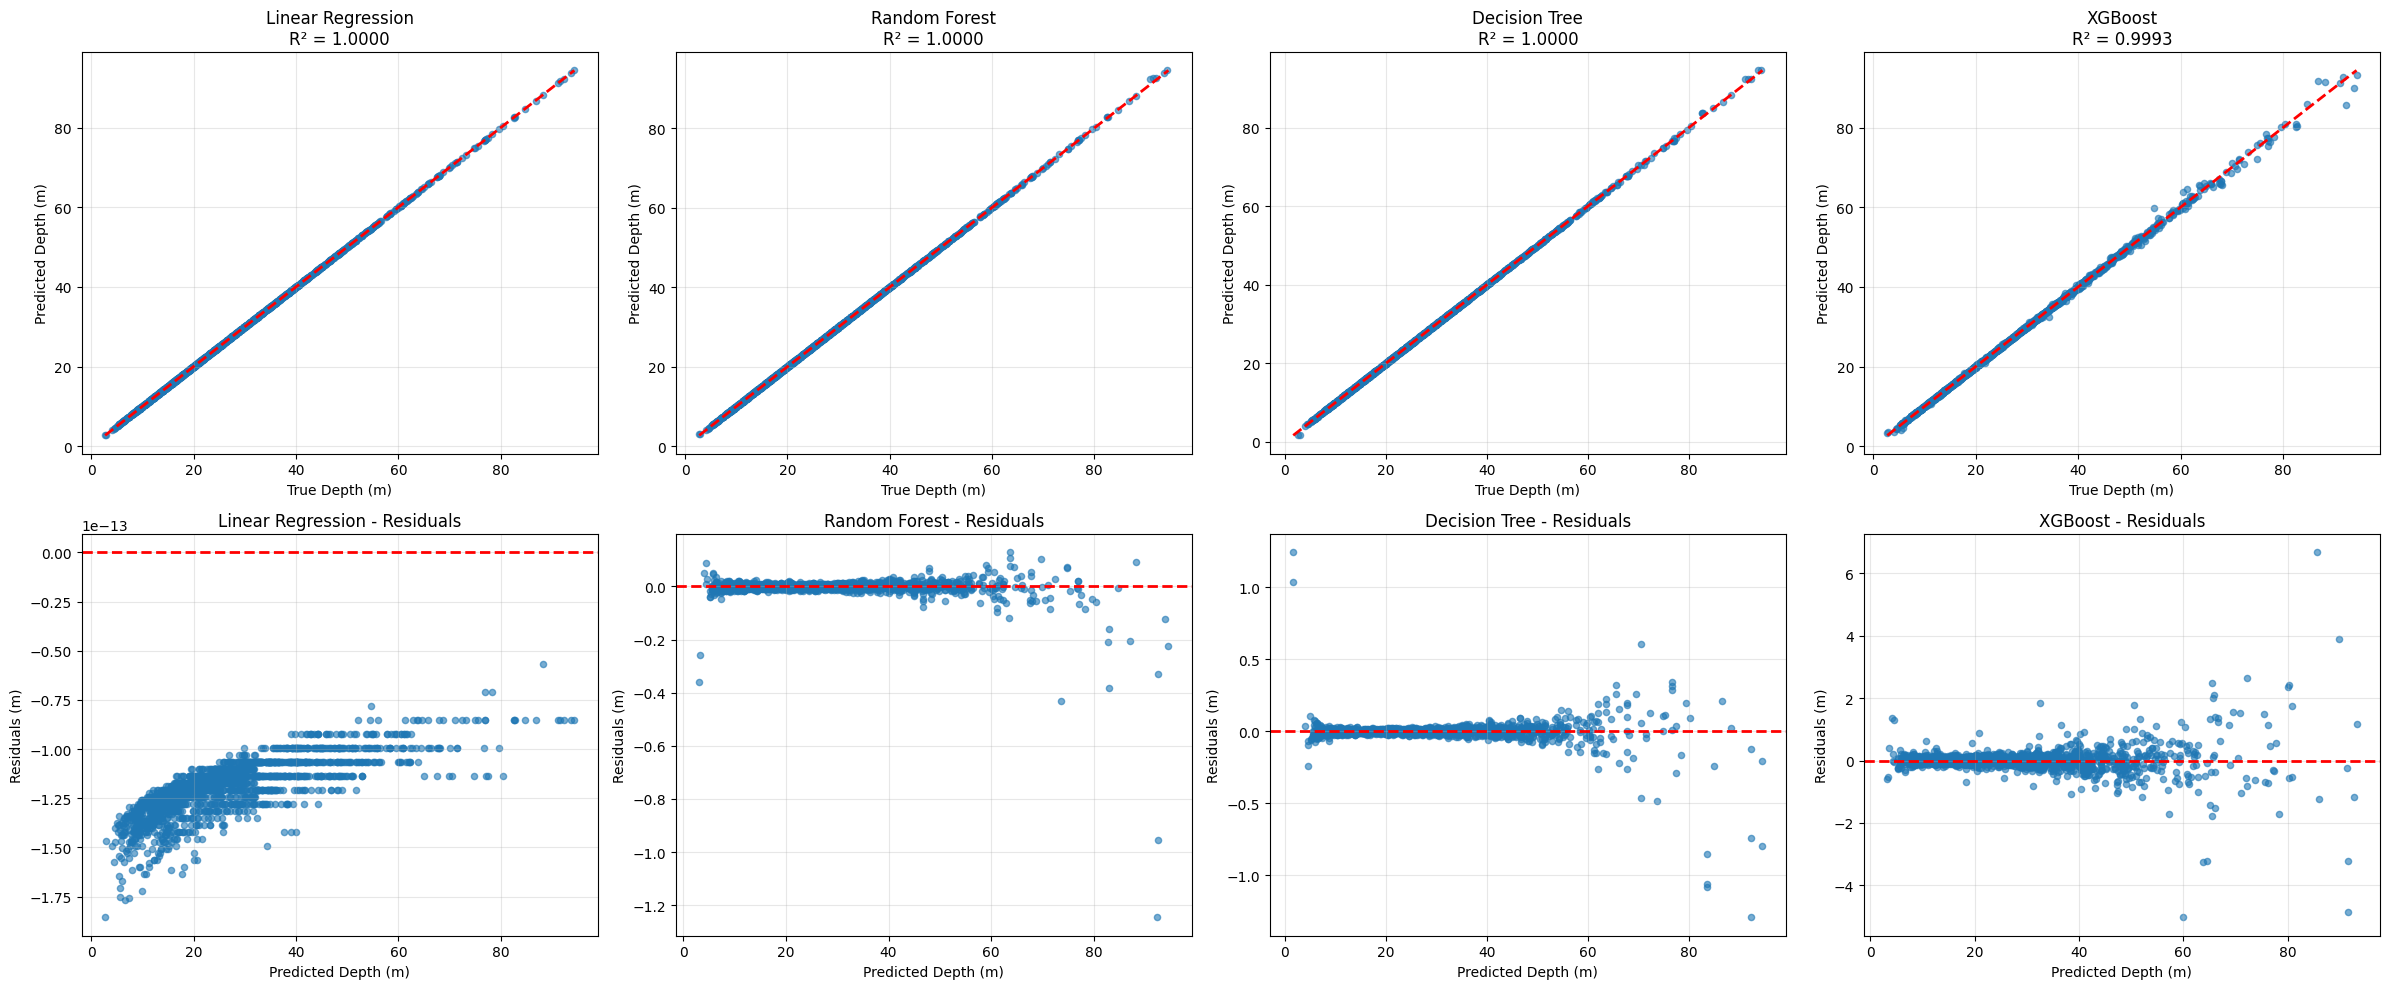


📊 Model Performance Summary:
                      mse    rmse     mae  r2_score
linear_regression  0.0000  0.0000  0.0000    1.0000
random_forest      0.0019  0.0433  0.0106    1.0000
decision_tree      0.0060  0.0777  0.0227    1.0000
xgboost            0.1557  0.3946  0.1658    0.9993

🏆 Best model: linear_regression (R² = 1.0000)
✅ Performance comparison saved to: d:\Project\sdb_project\outputs\kachchh\model_performance_comparison.csv
✅ Model metrics saved to: d:\Project\sdb_project\outputs\kachchh\model_metrics.json

🎯 Model training complete! Trained 4 models.
📁 Models saved to: d:\Project\sdb_project\models
📁 Results saved to: d:\Project\sdb_project\outputs\kachchh


In [11]:
# Create comparison visualizations
predictions = {
    'Linear Regression': lr_pred,
    'Random Forest': rf_pred,
    'Decision Tree': dt_pred
}

if 'xgboost' in model_results:
    predictions['XGBoost'] = xgb_pred

n_models = len(predictions)
fig, axes = plt.subplots(2, n_models, figsize=(6*n_models, 10))

if n_models == 1:
    axes = axes.reshape(2, 1)

# Scatter plots (True vs Predicted)
for idx, (name, pred) in enumerate(predictions.items()):
    ax = axes[0, idx]
    ax.scatter(y_test, pred, alpha=0.6, s=20)
    
    # Perfect prediction line
    min_val = min(y_test.min(), pred.min())
    max_val = max(y_test.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    ax.set_xlabel('True Depth (m)')
    ax.set_ylabel('Predicted Depth (m)')
    ax.set_title(f'{name}\nR² = {model_results[name.lower().replace(" ", "_")]["r2_score"]:.4f}')
    ax.grid(True, alpha=0.3)

# Residual plots
for idx, (name, pred) in enumerate(predictions.items()):
    ax = axes[1, idx]
    residuals = y_test - pred
    ax.scatter(pred, residuals, alpha=0.6, s=20)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    ax.set_xlabel('Predicted Depth (m)')
    ax.set_ylabel('Residuals (m)')
    ax.set_title(f'{name} - Residuals')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path(output_dir) / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Performance metrics comparison
metrics_df = pd.DataFrame(model_results).T
print("\n📊 Model Performance Summary:")
print("=" * 60)
print(metrics_df.round(4))

# Find best model
best_model_name = metrics_df['r2_score'].idxmax()
best_r2 = metrics_df.loc[best_model_name, 'r2_score']
print(f"\n🏆 Best model: {best_model_name} (R² = {best_r2:.4f})")

# Save performance comparison
metrics_df.to_csv(Path(output_dir) / 'model_performance_comparison.csv')
print(f"✅ Performance comparison saved to: {output_dir / 'model_performance_comparison.csv'}")

# Save all metrics as JSON
with open(Path(output_dir) / 'model_metrics.json', 'w') as f:
    json.dump(model_results, f, indent=2)

print(f"✅ Model metrics saved to: {output_dir / 'model_metrics.json'}")
print(f"\n🎯 Model training complete! Trained {len(model_results)} models.")
print(f"📁 Models saved to: {models_dir}")
print(f"📁 Results saved to: {output_dir}")

In [12]:
# Train models without depth_value feature for realistic evaluation
print("\n" + "="*80)
print("TRAINING MODELS WITH SPECTRAL FEATURES ONLY (REALISTIC TEST)")
print("="*80)

# Remove depth_value feature (index 8) for realistic training
spectral_features = np.delete(features, 8, axis=1)  # Remove depth_value column
spectral_feature_names = [name for i, name in enumerate(metadata['feature_names']) if i != 8]

print(f"📊 Spectral features shape: {spectral_features.shape}")
print(f"📊 Feature names: {spectral_feature_names}")

# Split spectral data
X_spec_train, X_spec_test, y_spec_train, y_spec_test = train_test_split(
    spectral_features, depths, test_size=0.2, random_state=42
)

# Train models with spectral features only
spectral_results = {}

# Linear Regression (Spectral)
print("\n🚀 Training Linear Regression (spectral only)...")
lr_spec = LinearRegression()
lr_spec.fit(X_spec_train, y_spec_train)
lr_spec_pred = lr_spec.predict(X_spec_test)
lr_spec_metrics = evaluate_model(y_spec_test, lr_spec_pred, "Linear Regression (Spectral)")
spectral_results['linear_regression_spectral'] = lr_spec_metrics

# Random Forest (Spectral) 
print("\n🚀 Training Random Forest (spectral only)...")
rf_spec = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_spec.fit(X_spec_train, y_spec_train)
rf_spec_pred = rf_spec.predict(X_spec_test)
rf_spec_metrics = evaluate_model(y_spec_test, rf_spec_pred, "Random Forest (Spectral)")
spectral_results['random_forest_spectral'] = rf_spec_metrics

# XGBoost (Spectral)
print("\n🚀 Training XGBoost (spectral only)...")
xgb_spec = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_spec.fit(X_spec_train, y_spec_train)
xgb_spec_pred = xgb_spec.predict(X_spec_test)
xgb_spec_metrics = evaluate_model(y_spec_test, xgb_spec_pred, "XGBoost (Spectral)")
spectral_results['xgboost_spectral'] = xgb_spec_metrics

# Save spectral models to region-specific directory
region_models_dir = project_dir / 'models' / region_slug
region_models_dir.mkdir(exist_ok=True)

# Save spectral models
joblib.dump(lr_spec, region_models_dir / "linear_regression.joblib")
joblib.dump(rf_spec, region_models_dir / "random_forest.joblib") 
joblib.dump(xgb_spec, region_models_dir / "xgboost.joblib")

# Save feature scaler for spectral features
from sklearn.preprocessing import StandardScaler
spectral_scaler = StandardScaler()
spectral_scaler.fit(X_spec_train)
joblib.dump(spectral_scaler, region_models_dir / "feature_scaler.joblib")

print(f"\n📊 REALISTIC SPECTRAL-ONLY PERFORMANCE SUMMARY:")
print("="*60)
for model_name, metrics in spectral_results.items():
    model_display = model_name.replace('_', ' ').title()
    print(f"{model_display}:")
    print(f"  RMSE: {metrics['rmse']:.4f}m")
    print(f"  MAE:  {metrics['mae']:.4f}m") 
    print(f"  R²:   {metrics['r2_score']:.4f}")

best_spectral_model = min(spectral_results.items(), key=lambda x: x[1]['rmse'])
print(f"\n🏆 Best spectral model: {best_spectral_model[0]} (RMSE: {best_spectral_model[1]['rmse']:.4f}m)")

# Save spectral results
spectral_metrics_path = region_models_dir / "metrics.json"
with open(spectral_metrics_path, 'w') as f:
    json.dump(spectral_results, f, indent=2)

print(f"✅ Spectral models saved to: {region_models_dir}")
print(f"✅ Spectral metrics saved to: {spectral_metrics_path}")


TRAINING MODELS WITH SPECTRAL FEATURES ONLY (REALISTIC TEST)
📊 Spectral features shape: (9754, 12)
📊 Feature names: ['blue_band', 'green_band', 'red_band', 'nir_band', 'swir1_band', 'swir2_band', 'nre_band', 'swir3_band', 'water_flag', 'latitude', 'longitude', 'lat_lon_interaction']

🚀 Training Linear Regression (spectral only)...

📊 Linear Regression (Spectral) Performance:
   MSE:  47.6293
   RMSE: 6.9014
   MAE:  4.7036
   R²:   0.7830

🚀 Training Random Forest (spectral only)...

📊 Random Forest (Spectral) Performance:
   MSE:  1.7558
   RMSE: 1.3251
   MAE:  0.4215
   R²:   0.9920

🚀 Training XGBoost (spectral only)...

📊 XGBoost (Spectral) Performance:
   MSE:  1.5317
   RMSE: 1.2376
   MAE:  0.3751
   R²:   0.9930

📊 REALISTIC SPECTRAL-ONLY PERFORMANCE SUMMARY:
Linear Regression Spectral:
  RMSE: 6.9014m
  MAE:  4.7036m
  R²:   0.7830
Random Forest Spectral:
  RMSE: 1.3251m
  MAE:  0.4215m
  R²:   0.9920
Xgboost Spectral:
  RMSE: 1.2376m
  MAE:  0.3751m
  R²:   0.9930

🏆 Best s